# Calculating Growth, DCF models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pull the income statement, balance sheet, and cash flow statement as downloaded from stockrow.com
ticker = 'JNJ'
ticker_inc_df = pd.read_excel(f'./Income/{ticker}_inc.xlsx').T
ticker_bal_df = pd.read_excel(f'./BalanceSheet/{ticker}_bal.xlsx').T
ticker_cfl_df = pd.read_excel(f'./CashFlow/{ticker}_cashflow.xlsx').T

# change the first row to be the column headers
ticker_inc_df.columns = ticker_inc_df.iloc[0]
ticker_bal_df.columns = ticker_bal_df.iloc[0]
ticker_cfl_df.columns = ticker_cfl_df.iloc[0]

#remove the first row
ticker_inc_df = ticker_inc_df.iloc[1:]
ticker_bal_df = ticker_bal_df.iloc[1:]
ticker_cfl_df = ticker_cfl_df.iloc[1:]

ticker_inc_df.head(2)

Unnamed: 0,Revenue,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expenses,Operating Income,Interest Expense (Operating),Non-operating Income/Expense,Non-operating Interest Expenses,EBT,...,Free Cash Flow Margin,EBITDA,EBIT,"EPS (Diluted, from Cont. Ops)","EPS (Basic, Consolidated)","EPS (Basic, from Continuous Ops)",Income from Continuous Operations,Consolidated Net Income/Loss,EBITDA Margin,Operating Cash Flow Margin
2021-03-31 00:00:00,8.4194e+10,2.8126e+10,5.6068e+10,1.2617e+10,2.2313e+10,1.7417e+10,7.4e+08,6.39e+09,5.9e+07,1.7417e+10,...,0.2583,2.8516e+10,1.7715e+10,5.658,5.7428,5.7428,1.5115e+10,1.5115e+10,0.3387,0.288
2020-12-31 00:00:00,8.2572e+10,2.7998e+10,5.4574e+10,1.2022e+10,2.2084e+10,1.6497e+10,7.24e+08,3.924e+09,1.11e+08,1.6497e+10,...,0.2482,2.7699e+10,1.6809e+10,5.5094,5.5887,5.5887,1.4714e+10,1.4714e+10,0.3355,0.285


#### Some data cleaning
Set columns we want, combine into one DF, create a field for FreeCashFlow (FCF)

In [3]:
# these are the columns we're interested in
inc_columns = ['Revenue','Gross Profit','Operating Income','Income Tax Provision', 'Net Income Common']
bal_columns = ['Total Assets','Total current assets','Total liabilities','Total current liabilities',
               'Shareholders Equity (Total)']#,'Shares (Common)']
cfl_columns = ['Dividends Paid (Common)','Capital expenditures','Operating Cash Flow']#,'Equity Repurchase (Common, Net)']

# this will apply only the columns above to each of our financial statement DataFrames
ticker_inc_df = ticker_inc_df[inc_columns]
ticker_bal_df = ticker_bal_df[bal_columns]
ticker_cfl_df = ticker_cfl_df[cfl_columns]

# this will combine or concatenate our three DataFrames into one
ticker_df = pd.concat([ticker_inc_df,ticker_bal_df,ticker_cfl_df], axis=1)

# defining a new column for FCF
ticker_df['FreeCashFlow'] = ticker_df['Operating Cash Flow'] - ticker_df['Capital expenditures']

ticker_df.head(2)

Unnamed: 0,Revenue,Gross Profit,Operating Income,Income Tax Provision,Net Income Common,Total Assets,Total current assets,Total liabilities,Total current liabilities,Shareholders Equity (Total),Dividends Paid (Common),Capital expenditures,Operating Cash Flow,FreeCashFlow
2021-03-31 00:00:00,8.4194e+10,5.6068e+10,1.7417e+10,2.302e+09,1.5115e+10,1.72557e+11,5.2533e+10,1.06723e+11,4.0932e+10,6.5834e+10,-1.0635e+10,-2.508e+09,2.4252e+10,2.676e+10
2020-12-31 00:00:00,8.2572e+10,5.4574e+10,1.6497e+10,1.783e+09,1.4714e+10,174894000000,51237000000,111616000000,42493000000,63278000000,-10481000000,-3042000000,23536000000,26578000000


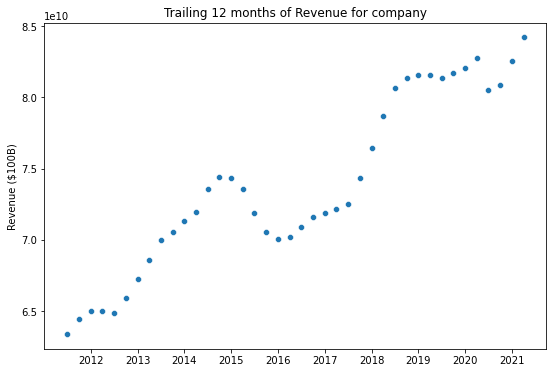

In [4]:
# TTM - Revenue
plt.figure(figsize=(9,6))
sns.scatterplot(x=ticker_df.index,y=ticker_df['Revenue'])
plt.title('Trailing 12 months of Revenue for company')
plt.ylabel('Revenue ($100B)');

## Growth rates 1
This method determines an average Revenue growth rate by taking the average of all 1-yr Revenue growth rates at t = 0, t = -1, t = -2 etc

In [5]:
# averaging all cumulative 1-yr revenue growths
rev_growth_list = [((ticker_df['Revenue'][i] - ticker_df['Revenue'][i+4]) / ticker_df['Revenue'][i+4]) 
                   for i in range(0,len(ticker_df['Revenue'])-4)]

print(f"Avg 1-yr Revenue growth rate: {round(sum(rev_growth_list)/len(rev_growth_list)*100,2)}%")

Avg 1-yr Revenue growth rate: 2.79%


##### Same for Free Cash Flow:

In [6]:
# averaging all FCF growth rates
fcf_growth_list1 = [((ticker_df['FreeCashFlow'][i] - ticker_df['FreeCashFlow'][i+4]) / ticker_df['FreeCashFlow'][i+4]) 
                   for i in range(0,len(ticker_df['FreeCashFlow'])-4)]

fcf_growth_rate1 = sum(fcf_growth_list1)/len(fcf_growth_list1)
print(f"Free Cash Flow average 1-yr growth rate: {round(fcf_growth_rate1*100,2)}%")

Free Cash Flow average 1-yr growth rate: 6.02%


##### Same for *every* financial metric

In [7]:
#calculating all cumulative 1-yr average growths at once
growth_list1 = []
for col in ticker_df.columns:
    try:
        col_growth_list1 = [((ticker_df[col][i] - ticker_df[col][i+4]) / ticker_df[col][i+4]) 
                           for i in range(0,len(ticker_df[col])-4)]
        print(f"Avg growth for {col} is {sum(col_growth_list1)/len(col_growth_list1)}")
        growth_list1.append(sum(col_growth_list1)/len(col_growth_list1))
    except:
        print(f"{col} throws an error")

all_metrics_growth_rate1 = sum(growth_list1)/len(growth_list1) 
print(f"Avg growth: {all_metrics_growth_rate1}")

Avg growth for Revenue is 0.027881847069147068
Avg growth for Gross Profit is 0.023436042644340745
Avg growth for Operating Income is 0.04092908248112464
Avg growth for Income Tax Provision is 0.3878437096652051
Avg growth for Net Income Common is 1.0916913022906813
Avg growth for Total Assets is 0.046264858849757506
Avg growth for Total current assets is 0.011555165343705999
Avg growth for Total liabilities is 0.08219624306512295
Avg growth for Total current liabilities is 0.07606358351746251
Avg growth for Shareholders Equity (Total) is 0.010134943526124518
Avg growth for Dividends Paid (Common) is 0.06080488945934199
Avg growth for Capital expenditures is -54.18138670820968
Avg growth for Operating Cash Flow is 0.051797744937704976
Avg growth for FreeCashFlow is 0.06021797073174692
Avg growth: -3.7293263803305865


In [8]:
# this code sorts the growth rates from low to high, 
# then it removes the top 2 and lowest 2
growth_list1.sort()
normalized_ticker_growth1 = sum(growth_list1[2:-2]) / len(growth_list1[2:-2])

print(f"The 'normalized' growth rate for (almost all) metrics: {round(normalized_ticker_growth1*100,2)}%")

The 'normalized' growth rate for (almost all) metrics: 4.81%


## Growth rates 2
This method determines an average Revenue growth rate by taking the 1-yr, 2-yr, 3-yr etc. growth rates and averaging them all together

In [9]:
#this version only considers growth rate starting from t = 0, looking backwards at quarterly data
fcf_growth_list2 = [((1+((ticker_df['FreeCashFlow'][0] - ticker_df['FreeCashFlow'][i+4]) / ticker_df['FreeCashFlow'][i+4]))**(1/(1+i/4))-1) 
                    for i in range(len(ticker_df['FreeCashFlow'])-4)]

fcf_growth_rate2 = sum(fcf_growth_list2)/len(fcf_growth_list2)
print(f"Free Cash Flow avg growth rate last decade: {round(fcf_growth_rate2*100,2)}%")

Free Cash Flow avg growth rate last decade: 6.8%


In [10]:
growth_list2 = []
for col in ticker_df.columns:
    try:
        col_growth_list2 = [((1+((ticker_df[col][0] - ticker_df[col][i+4]) / ticker_df[col][i+4]))**(1/(1+i/4))-1) 
                            for i in range(len(ticker_df[col])-4)]
        print(f"Avg growth for {col} is {sum(col_growth_list2)/len(col_growth_list2)}")
        growth_list2.append(sum(col_growth_list2)/len(col_growth_list2))
    except:
        print(f'{col} throws an error')
        
all_metrics_growth_rate2 = sum(growth_list2)/len(growth_list2) 
print(f"Avg growth of all metrics: {all_metrics_growth_rate2}")

Avg growth for Revenue is 0.02656815570932996
Avg growth for Gross Profit is 0.022623895985544526
Avg growth for Operating Income is -0.0027165800582355545
Avg growth for Income Tax Provision is -0.09158436158704936
Avg growth for Net Income Common is 0.15236312801432816
Avg growth for Total Assets is 0.0481078081763801
Avg growth for Total current assets is 0.022461354360559016
Avg growth for Total liabilities is 0.08492195957092265
Avg growth for Total current liabilities is 0.10411673364391914
Avg growth for Shareholders Equity (Total) is 0.005553543106502795
Avg growth for Dividends Paid (Common) is 0.05458019843639457
Avg growth for Capital expenditures is (0.45915164493859223+0.19429835485566224j)
Avg growth for Operating Cash Flow is 0.04855209703185871
Avg growth for FreeCashFlow is 0.0679553697214758
Avg growth of all metrics: (0.07161821050360877+0.013878453918261589j)


In [11]:
# this code sorts the growth rates from low to high, 
# then it removes the top 2 and lowest 2
growth_list2.sort()
normalized_ticker_growth2 = sum(growth_list2[2:-2]) / len(growth_list2[2:-2])

print(f"The 'normalized' growth rate for (almost all) metrics: {round(normalized_ticker_growth2*100,2)}%")

TypeError: '<' not supported between instances of 'complex' and 'float'

## DCF Models

In [47]:
# DCF using the treasury rate as the discount rate and avg. FCF growth as growth rate
discount_rate = 0.0163

def dcf_maker(ticker_df,growth_rate,discount_rate,years):
    # we start at zero, then incrementally add each subsequent year's FCF
    fcf_over_time = 0
    # our base will be the most recent year's FCF
    fcf_start = ticker_df['FreeCashFlow'][0]

    # covering a range of 10 years
    for i in range(1,years+1):
        fcf_over_time += fcf_start * (1+growth_rate)**i / (1+discount_rate)**i

    print(f"Total FCF: ${round(fcf_over_time/1_000_000_000,1)} billion")
    return fcf_over_time

In [48]:
test1 = dcf_maker(ticker_df=ticker_df,growth_rate=0.1,discount_rate=0.0163,years=10)

Total FCF: $33.4 billion


In [49]:
all_growth_rates = [fcf_growth_rate1,fcf_growth_rate2,all_metrics_growth_rate1,all_metrics_growth_rate2,
                    normalized_ticker_growth1, normalized_ticker_growth2]
discount_list = np.linspace(0.01,0.08,20).tolist()
year_list = [8,9,10,11,12]

fcf_values_list = []
for rate in all_growth_rates:
    for discount in discount_list:
        for year in year_list:
            #print(f"Growth rate: {round(rate*100,2)}%, Discount rate: {round(discount*100,2)}%, Years: {year}")
            fcf_values_list.append(dcf_maker(ticker_df,rate,discount,year))

Total FCF: $38.6 billion
Total FCF: $48.1 billion
Total FCF: $59.4 billion
Total FCF: $72.8 billion
Total FCF: $88.6 billion
Total FCF: $37.8 billion
Total FCF: $47.1 billion
Total FCF: $58.0 billion
Total FCF: $70.8 billion
Total FCF: $86.0 billion
Total FCF: $37.1 billion
Total FCF: $46.1 billion
Total FCF: $56.6 billion
Total FCF: $68.9 billion
Total FCF: $83.4 billion
Total FCF: $36.4 billion
Total FCF: $45.1 billion
Total FCF: $55.2 billion
Total FCF: $67.1 billion
Total FCF: $80.9 billion
Total FCF: $35.7 billion
Total FCF: $44.1 billion
Total FCF: $53.9 billion
Total FCF: $65.3 billion
Total FCF: $78.6 billion
Total FCF: $35.0 billion
Total FCF: $43.2 billion
Total FCF: $52.6 billion
Total FCF: $63.6 billion
Total FCF: $76.3 billion
Total FCF: $34.4 billion
Total FCF: $42.3 billion
Total FCF: $51.4 billion
Total FCF: $61.9 billion
Total FCF: $74.1 billion
Total FCF: $33.8 billion
Total FCF: $41.4 billion
Total FCF: $50.2 billion
Total FCF: $60.3 billion
Total FCF: $72.0 billion


In [50]:
sum(fcf_values_list) / len(fcf_values_list) / 1000000000

40.34479983067359

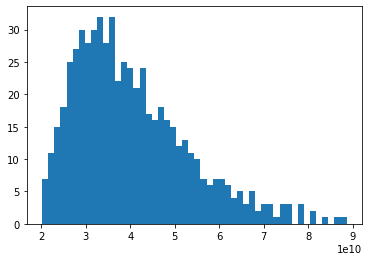

In [51]:
fcf_values_list.sort
len(fcf_values_list)
plt.hist(fcf_values_list,bins=50);

In [21]:
from bokeh.io import show, output_file
from bokeh.plotting import figure

data = fcf_values_list
hist, edges = np.histogram(data, density=True, bins=50)

p = figure()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")

output_file("hist.html")
show(p)

In [40]:
growth_rate = fcf_growth_rate1
discount_rate = 0.05
years=15

dcf_maker(ticker_df,growth_rate,discount_rate,years)

Total FCF: $2440.4 billion


2440382848259.369

In [41]:
np.linspace(0.01,0.15,15)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15])

In [14]:
# Calculate most recent FCF, next year FCF, and discount next year's FCF
# discount_rate is treasury rate here
bill = 1_000_000_000
discount_rate = 0.0163

print(f"Most recent FCF: ${round(ticker_df['FreeCashFlow'][0]/bill,2)} billion")
print(f"Next year FCF: ${round(ticker_df['FreeCashFlow'][0]*(1+fcf_growth_rate1)/bill,2)} billion")
print(f"Next year FCF, discounted: ${round(ticker_df['FreeCashFlow'][0]*(1+fcf_growth_rate1)**(1)/(1+discount_rate)/bill,2)} billion")

Most recent FCF: $108.71 billion
Next year FCF: $119.62 billion
Next year FCF, discounted: $117.7 billion


In [15]:
# DCF using the treasury rate as the discount rate and avg. FCF growth as growth rate
treasury_rate = 0.0163
# we start at zero, then incrementally add each subsequent year's FCF
fcf_over_time1 = 0
# our base will be the most recent year's FCF
fcf_start = ticker_df['FreeCashFlow'][0]

# covering a range of 10 years
for i in range(1,10+1):
    fcf_over_time1 += fcf_start * (1+fcf_growth_rate1)**i / (1+treasury_rate)**i
    print(f"Year {i}: ${round(fcf_start * (1+fcf_growth_rate1)**i / (1+treasury_rate)**i / 1_000_000_000,1)} billion")

print(f"Total FCF: ${round(fcf_over_time1/1_000_000_000,1)} billion")

Year 1: $117.7 billion
Year 2: $127.4 billion
Year 3: $138.0 billion
Year 4: $149.4 billion
Year 5: $161.7 billion
Year 6: $175.1 billion
Year 7: $189.6 billion
Year 8: $205.3 billion
Year 9: $222.2 billion
Year 10: $240.6 billion
Total FCF: $1726.9 billion


In [16]:
# DCF using 5% as the discount rate and avg. FCF growth as growth rate
discount_rate = 0.05
# we start at zero, then incrementally add each subsequent year's FCF
fcf_over_time = 0
# our base will be the most recent year's FCF
fcf_start = ticker_df['FreeCashFlow'][0]

# covering a range of 15 years
for i in range(1,15+1):
    fcf_over_time += fcf_start * (1+fcf_growth_rate1)**i / (1+discount_rate)**i
    print(f"Year {i}: ${round(fcf_start * (1+fcf_growth_rate1)**i / (1+discount_rate)**i / 1_000_000_000,1)} billion")

print(f"Total FCF: ${round(fcf_over_time/1_000_000_000,1)} billion")

Year 1: $113.9 billion
Year 2: $119.4 billion
Year 3: $125.1 billion
Year 4: $131.1 billion
Year 5: $137.4 billion
Year 6: $144.0 billion
Year 7: $150.9 billion
Year 8: $158.1 billion
Year 9: $165.7 billion
Year 10: $173.6 billion
Year 11: $181.9 billion
Year 12: $190.7 billion
Year 13: $199.8 billion
Year 14: $209.4 billion
Year 15: $219.4 billion
Total FCF: $2420.4 billion


In [18]:
# turning FCF into per-share stock price predictions
ticker_fcf1 = round(fcf_over_time1/ticker_df['Shares (Common)'][0],2)
ticker_fcf2 = round(fcf_over_time/ticker_df['Shares (Common)'][0],2)

avg_fcf = round((ticker_fcf1 + ticker_fcf2)/2,2)

print(f"Total FCF per share, v1: ${ticker_fcf1}")
print(f"Total FCF per share, v2: ${ticker_fcf2}")
print(f"Average FCF per share: ${avg_fcf}")

Total FCF per share, v1: $103.49
Total FCF per share, v2: $145.05
Average FCF per share: $124.27


In [19]:
# DCF using treasury as discount rate and all AAPL growth as growth rate
treasury_rate = 0.05
fcf_over_time = 0
fcf_start = ticker_df['FreeCashFlow'][0]
for i in range(1,15+1):
    fcf_over_time += fcf_start * (1+normalized_ticker_growth)**i / (1+treasury_rate)**i

fcf_over_time/1_000_000_000

2291.3389834781656

In [18]:
# if total growth over 5 years is 180%
# then the growth rate is:
growth_180 = 1.8**(1/5)
growth_180

1.1247461131420948

In [19]:
for i in range(0,25):
    print(f"{1+i/4} - {1.80**(1/(1+i/4))}")

1.0 - 1.8
1.25 - 1.60036116503796
1.5 - 1.479727244598282
1.75 - 1.399168447706693
2.0 - 1.3416407864998738
2.25 - 1.2985373526865052
2.5 - 1.2650538190282499
2.75 - 1.2383014044559357
3.0 - 1.21644039911468
3.25 - 1.1982443398361224
3.5 - 1.1828645094459014
3.75 - 1.1696950930790704
4.0 - 1.158292185288269
4.25 - 1.1483231463818495
4.5 - 1.139533831304058
4.75 - 1.1317267469617007
5.0 - 1.1247461131420948
5.25 - 1.118467410511232
5.5 - 1.1127899192821329
5.75 - 1.1076312962277344
6.0 - 1.1029235690267392
6.25 - 1.098610134036251
6.5 - 1.0946434761309831
6.75 - 1.0909834159010432
7.0 - 1.0875957472544207
